# Dataset 3: Heart Disease

This notebook benchmarks three classification models on the Heart Disease
dataset and analyzes their predictions using explainable AI techniques,
including SHAP, LIME, and counterfactual explanations.

## Dataset description

The Heart Disease dataset contains medical attributes describing patients,
with the goal of predicting the presence of heart disease.

The task is formulated as a binary classification problem:
- 0 — no heart disease
- 1 — presence of heart disease


In [1]:
%pip install numpy pandas scikit-learn matplotlib seaborn shap lime dice-ml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


----

In [2]:
import numpy as np
import pandas as pd

from lime.lime_tabular import LimeTabularExplainer

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import dice_ml
from dice_ml import Dice

import seaborn as sns
import matplotlib.pyplot as plt
import shap

C:\Users\Adrian\Desktop\XAI UJ\counterfactual-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----

In [3]:
#LOAD DATA
data = fetch_openml("heart-disease", version=1, as_frame=True)

X = data.data.drop(columns="target").copy()
y = data.data["target"].copy()

X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0


In [4]:
# The dataset contains 303 instances with 13 numerical features.
# The target variable indicates the presence of heart disease
# (1 = presence, 0 = absence). The class distribution is
# moderately imbalanced, with 165 positive and 138 negative cases.

X.shape, y.value_counts()

((303, 13),
 target
 1.0    165
 0.0    138
 Name: count, dtype: int64)

In [5]:
## Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


----

# Benchmark

In [6]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}


In [7]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy


# Find model with most accuracy - we will perform explanation on picked model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

best_model_name


'Random Forest'

---

# XAI


## Feature importance


In [8]:
importances = best_model.feature_importances_

feature_importance = (
    pd.Series(importances, index=X.columns)
    .sort_values(ascending=False)
)

feature_importance.head(10)

cp          0.153487
thal        0.126282
oldpeak     0.124415
thalach     0.116339
ca          0.079189
chol        0.076480
age         0.073022
trestbps    0.069618
slope       0.062400
exang       0.061043
dtype: float64

## SHAP

In [9]:
# SHAP setup
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap_values


array([[[-0.01332544,  0.01332544],
        [ 0.02337454, -0.02337454],
        [-0.10286055,  0.10286055],
        ...,
        [ 0.06834098, -0.06834098],
        [ 0.04334541, -0.04334541],
        [ 0.10040204, -0.10040204]],

       [[ 0.01123035, -0.01123035],
        [ 0.01836087, -0.01836087],
        [ 0.1029872 , -0.1029872 ],
        ...,
        [ 0.04786081, -0.04786081],
        [ 0.04740713, -0.04740713],
        [ 0.09142269, -0.09142269]],

       [[ 0.02946859, -0.02946859],
        [ 0.02981685, -0.02981685],
        [-0.0865426 ,  0.0865426 ],
        ...,
        [-0.0422489 ,  0.0422489 ],
        [ 0.08117281, -0.08117281],
        [-0.10425919,  0.10425919]],

       ...,

       [[ 0.03558413, -0.03558413],
        [-0.05441555,  0.05441555],
        [-0.11814735,  0.11814735],
        ...,
        [-0.04435273,  0.04435273],
        [ 0.02635432, -0.02635432],
        [-0.08407564,  0.08407564]],

       [[ 0.04557825, -0.04557825],
        [-0.03529932,  0.03

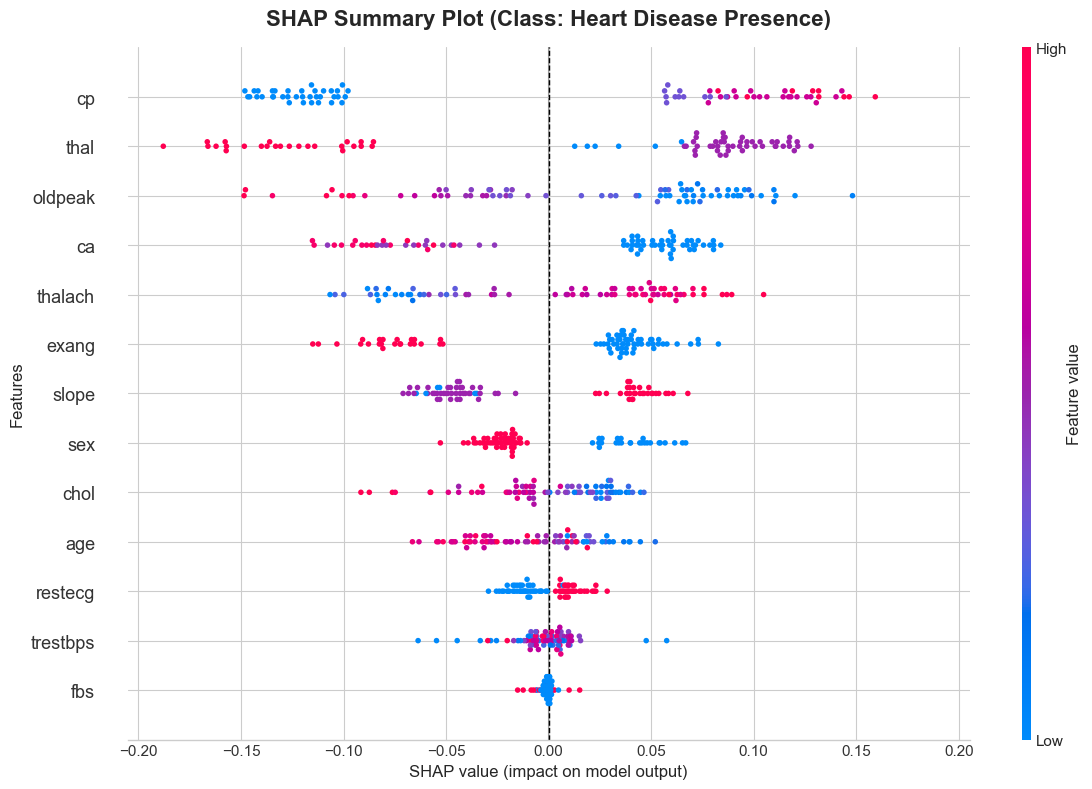

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(12, 8))

shap_values_pos = shap_values[:, :, 1]

shap.summary_plot(
    shap_values_pos,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),
    color_bar=True
)

ax = plt.gca()

ax.axvline(0, color="black", linestyle="--", linewidth=1)
max_abs = np.abs(ax.get_xlim()).max()
ax.set_xlim(-max_abs, max_abs)

plt.title(
    "SHAP Summary Plot (Class: Heart Disease Presence)",
    fontsize=16,
    weight="bold",
    pad=16
)

plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()


## LIME

In [11]:
#LIME setup

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["No Heart Disease", "Heart Disease"],
    discretize_continuous=True,
    mode="classification"
)

index = 0
instance_series = X_test.iloc[index]
instance_np = instance_series.values
instance_series


age          70.0
sex           1.0
cp            2.0
trestbps    160.0
chol        269.0
fbs           0.0
restecg       1.0
thalach     112.0
exang         1.0
oldpeak       2.9
slope         1.0
ca            1.0
thal          3.0
Name: 240, dtype: float64

C:\Users\Adrian\Desktop\XAI UJ\counterfactual-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


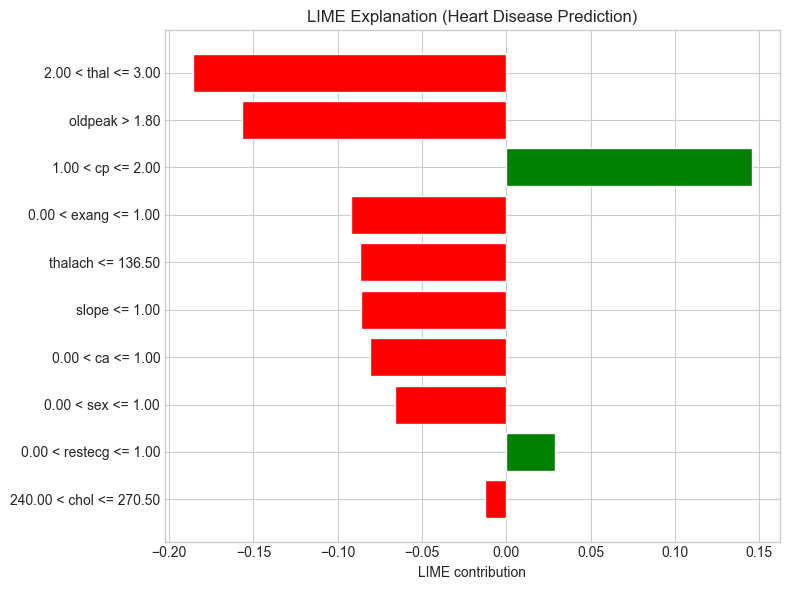

In [12]:
def predict_proba_model(x):
    return best_model.predict_proba(x)


lime_exp = lime_explainer.explain_instance(
    data_row=instance_np,
    predict_fn=predict_proba_model,
    num_features=10
)

exp = lime_exp.as_list()

features = [x[0] for x in exp]
values = [x[1] for x in exp]

plt.figure(figsize=(8, 6))
colors = ["green" if v > 0 else "red" for v in values]

plt.barh(features, values, color=colors)
plt.xlabel("LIME contribution")
plt.title("LIME Explanation (Heart Disease Prediction)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

## Counterfactual Explanations (DiCE)

In [13]:
#DiCE setup

df = X.copy()
df["target"] = y

continuous_features = [
    "age",
    "trestbps",
    "chol",
    "thalach",
    "oldpeak"
]

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    outcome_name="target"
)

dice_model = dice_ml.Model(
    model=best_model,
    backend="sklearn",
    model_type="classifier"
)

dice = Dice(
    dice_data,
    dice_model,
    method="random"
)

query_instance = instance_series.to_frame().T
query_instance


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
240,70.0,1.0,2.0,160.0,269.0,0.0,1.0,112.0,1.0,2.9,1.0,1.0,3.0


In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

cf = dice.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_class=0
)


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


In [15]:
cf_df = cf.cf_examples_list[0].final_cfs_df
original = query_instance.iloc[0]
diff = cf_df[X.columns] - original[X.columns]
diff_changed = diff.loc[:, (diff != 0).any(axis=0)]

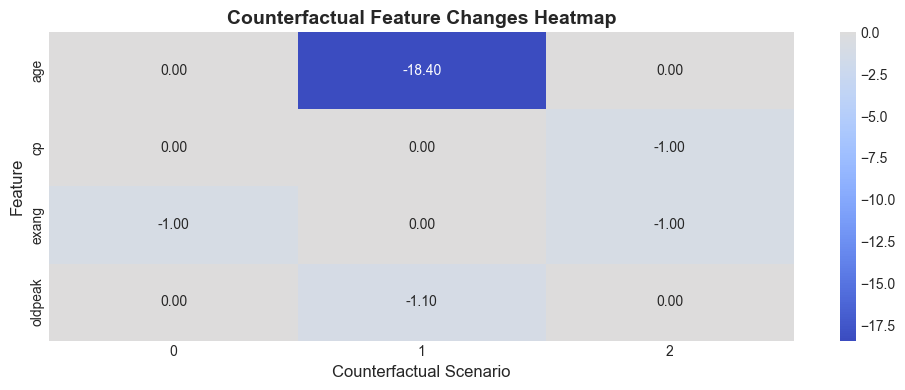

In [16]:
plt.figure(figsize=(10, 4))
sns.heatmap(
    diff_changed.T,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)

plt.title("Counterfactual Feature Changes Heatmap", fontsize=14, weight="bold")
plt.xlabel("Counterfactual Scenario", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

----

## Evaluation

#### VALIDITY

In [17]:
desired_class = 0
cf_features = cf_df[X.columns]
cf_preds = best_model.predict(cf_features)
orig = query_instance.iloc[0][X.columns]
cf_X = cf_features
l1_distance = (cf_X - orig).abs().sum(axis=1)

In [18]:
validity = cf_preds == desired_class

validity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(cf_preds))],
    "Predicted class": cf_preds,
    "Valid (prediction flipped)": validity
})

validity_df


,Counterfactual,Predicted class,Valid (prediction flipped)
0,CF_0,0.0,True
1,CF_1,0.0,True
2,CF_2,0.0,True


#### SPARSITY

In [19]:
sparsity = (cf_X != orig).sum(axis=1)

sparsity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(sparsity))],
    "Sparsity (number of features changed)": sparsity
})

sparsity_df


,Counterfactual,Sparsity (number of features changed)
0,CF_0,1
1,CF_1,2
2,CF_2,2


#### PROXIMITY


In [20]:
proximity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(l1_distance))],
    "Proximity (L1 distance)": l1_distance
})

proximity_df


,Counterfactual,Proximity (L1 distance)
0,CF_0,1.0
1,CF_1,19.5
2,CF_2,2.0


#### PLAUSIBILITY

In [21]:
def plausible(cf_row, X):
    return ((cf_row >= X.min()) & (cf_row <= X.max())).all()

plausibility = cf_features.apply(lambda row: plausible(row, X), axis=1)

plausibility_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(plausibility))],
    "Plausible (within data range)": plausibility
})

plausibility_df

,Counterfactual,Plausible (within data range)
0,CF_0,True
1,CF_1,True
2,CF_2,True


The generated counterfactual explanations were evaluated using multiple complementary criteria. All counterfactuals successfully flipped the model prediction to the desired class, resulting in a validity score of 100%, which confirms that the counterfactuals effectively cross the model’s decision boundary.

Sparsity analysis showed that the counterfactuals required modifications to only one or two features, indicating that the explanations are concise and easy to interpret. Such low sparsity suggests that the model’s decision can be altered through minimal, targeted changes rather than widespread feature adjustments.

Proximity was assessed using the L1 distance, revealing variability in the magnitude of required changes. While some counterfactuals involved very small adjustments and remained close to the original instance, others required substantially larger changes. This indicates the presence of multiple counterfactual paths, some of which are more conservative and others that rely on more pronounced feature shifts.

Plausibility analysis confirmed that all counterfactual feature values remained within the observed range of the training data, suggesting that the generated instances are consistent with the underlying data distribution. However, counterfactuals with larger proximity values may still be less practical in real-world scenarios despite remaining within valid data bounds.

Overall, the evaluation indicates a stable decision boundary with several valid and interpretable counterfactual explanations. The results demonstrate that the model allows for multiple plausible paths to alter its prediction, balancing sparsity and proximity while maintaining full validity.

----